In [1]:
import numpy as np
import pandas as pd 
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/home/jonathan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def plot_distribution_feature(df, fname, label_col='is_duplicate'):
    fig = plt.figure(figsize=(16,12))
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    ax1.set_title('Distribution of %s' % fname, fontsize=20)
    sns.distplot(df[fname], bins=50, ax=ax1)    
    sns.distplot(df.loc[df[label_col]==1][fname], bins=50, ax=ax2, label='positive')    
    sns.distplot(df.loc[df[label_col]==0][fname], bins=50, ax=ax2, label='negative')
    ax2.legend(loc='upper right', prop={'size': 18})
    sns.boxplot(y=fname, x=label_col, data=df, ax=ax3)
    sns.violinplot(y=fname, x=label_col, data=df, ax=ax4)
    plt.show()

In [3]:
train_data = pd.read_csv('data/train.csv', index_col='id')
train_data = train_data.fillna("")
train_data.shape

(404290, 5)

In [4]:
features = ['distance', 'tfidf_lsa_100_features', 'word_idf_features', 'word_pos_features', 'word_share_features']

def load_features(data_type, features, typ="clean"):
    
    data_feat = []
    for feature in features:
        data_feat.append(pd.read_csv('features/{}_{}_{}.csv'.format(typ, data_type, feature)))
        
    return pd.concat(data_feat,axis=1)

In [47]:
clean_train_features = load_features('train', features + ['fuzzy_features'])
clean_train_features.drop('id',axis=1,inplace=True)

stem_train_features = load_features('train', features, typ='stem')
stem_train_features.drop('id',axis=1,inplace=True)

lem_train_features = load_features('train', features, typ='lem')
lem_train_features.drop('id',axis=1,inplace=True)

In [48]:
train_features = pd.concat([clean_train_features,stem_train_features,lem_train_features],axis=1)

In [49]:
x_train = train_features.ix[0:350000]
x_test = train_features.ix[350000:]
y_train = train_data.ix[0:350000,'is_duplicate']
y_test = train_data.ix[350000:,'is_duplicate']

In [50]:
from sklearn.metrics import log_loss, make_scorer

xgb_params = {
    'max_depth': 7, 
    'learning_rate': 0.1,
    'n_estimators': 300, 
    'objective': 'binary:logistic',
    'nthread': 8, 
    'gamma': 0, 
    'subsample': 0.75, 
    'colsample_bytree': 0.75, 
    'colsample_bylevel': 1,
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'scale_pos_weight': 1
}

model = xgb.XGBClassifier(silent=False).set_params(**xgb_params)

In [51]:
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.75,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=300, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=0.75)

In [52]:
proba = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)

0.885179054256
0.395212804641


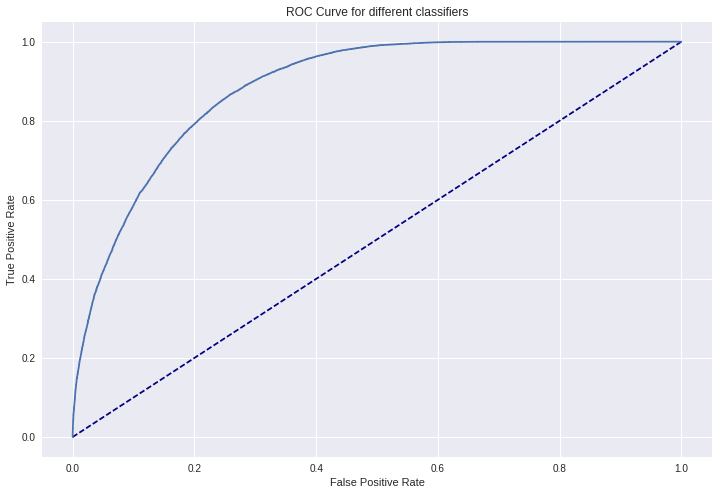

In [53]:
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import precision_recall_curve, auc, roc_curve
plt.figure(figsize=(12,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different classifiers')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)
print(roc_auc)
print(log_loss(y_test,proba))
plt.plot(fpr, tpr)

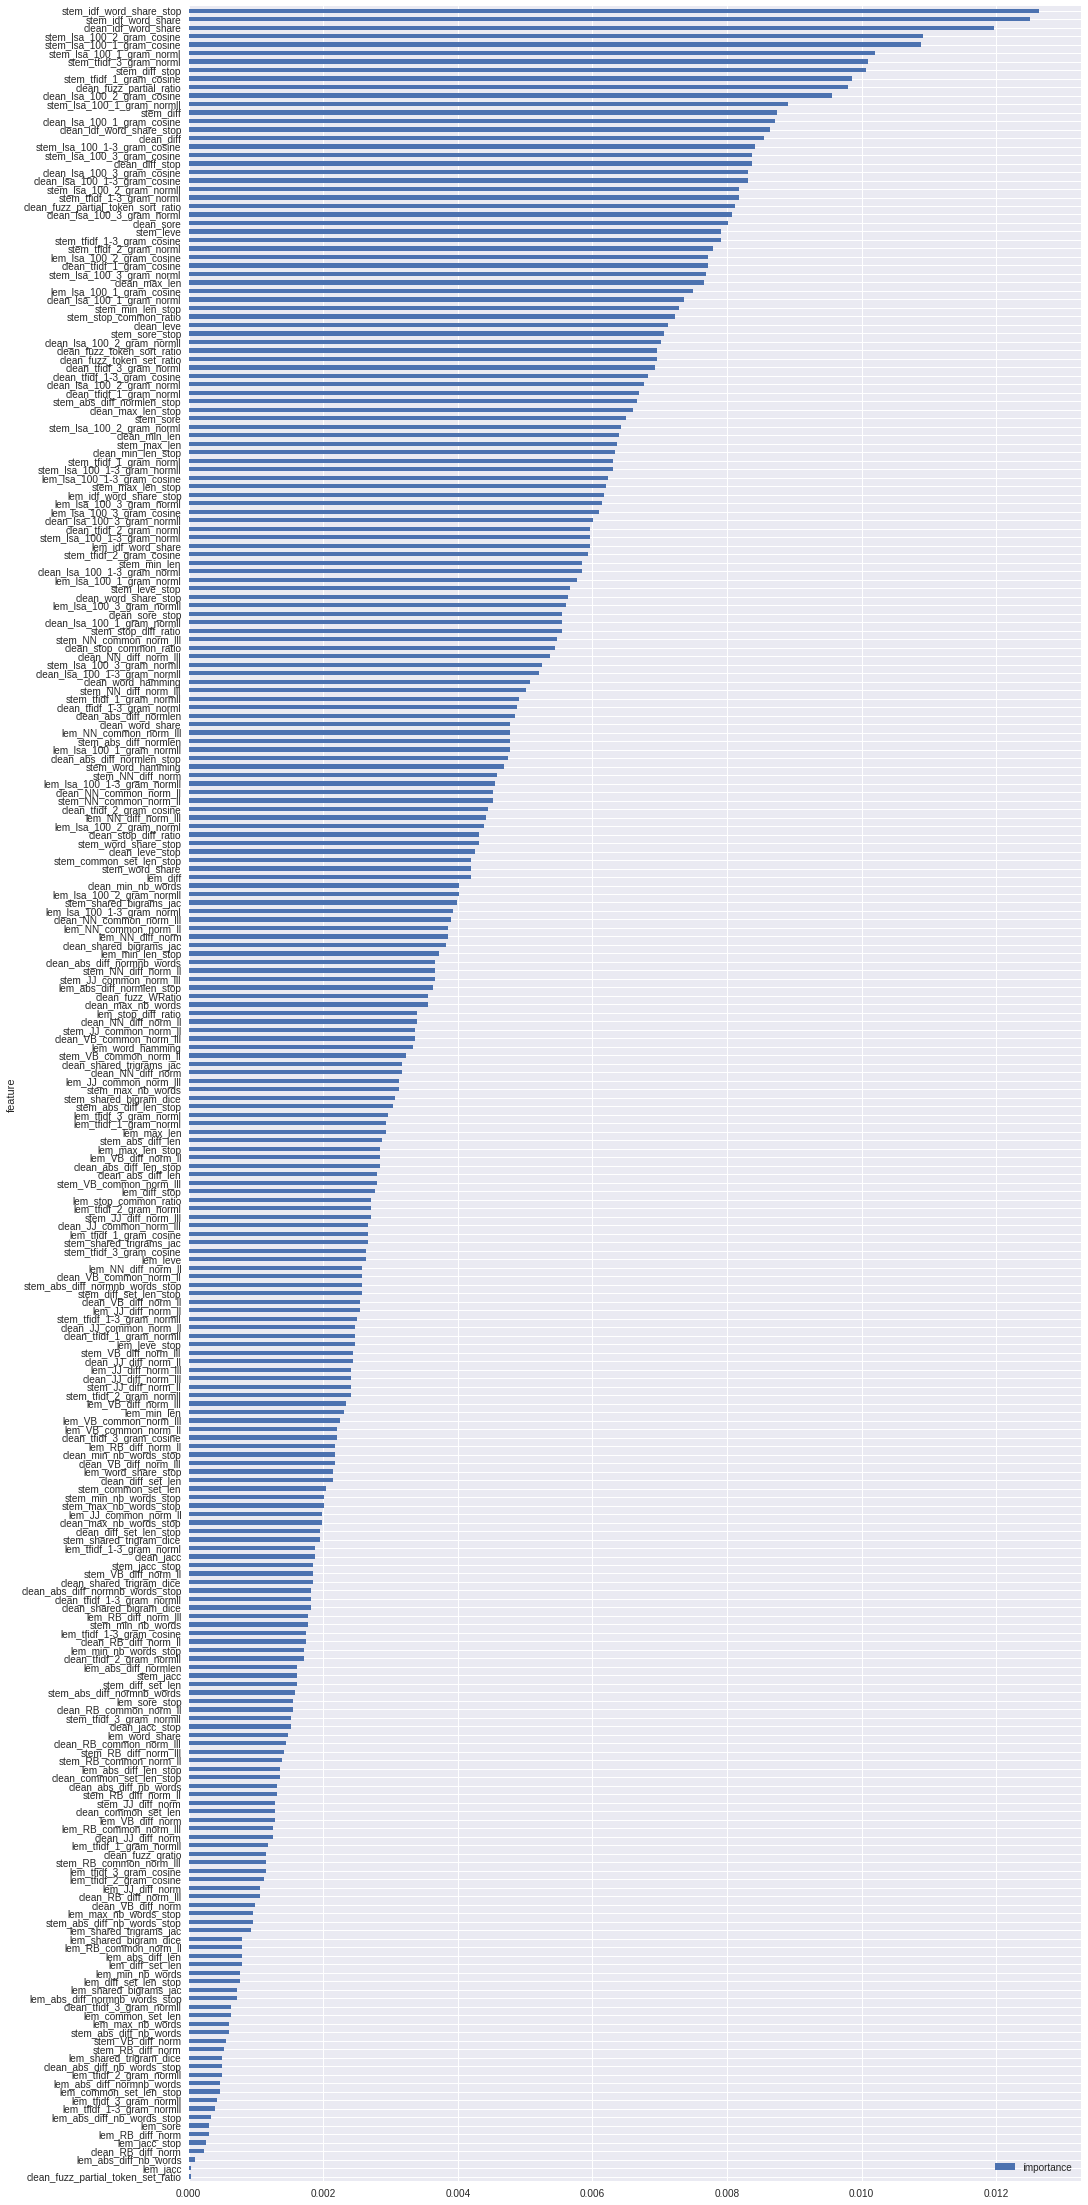

In [56]:
cols = x_train.columns
fi = pd.DataFrame([(cols[i],model.feature_importances_[i]) for i in range(len(cols))], columns=['feature','ímportance'])
fi = fi.sort_values(fi.columns[1],ascending=True).reset_index()
fi.plot(kind='barh',x='feature',y='ímportance',figsize=(16,40),sort_columns=True)

In [40]:
def link_function(x,a=0.165 / 0.37, b= (1 - 0.165) / (1 - 0.37) ):
     return a * x / (a * x + b * (1 - x))

In [45]:
linked_proba = list(map(link_function,proba))

0.884491484386
0.464111756835


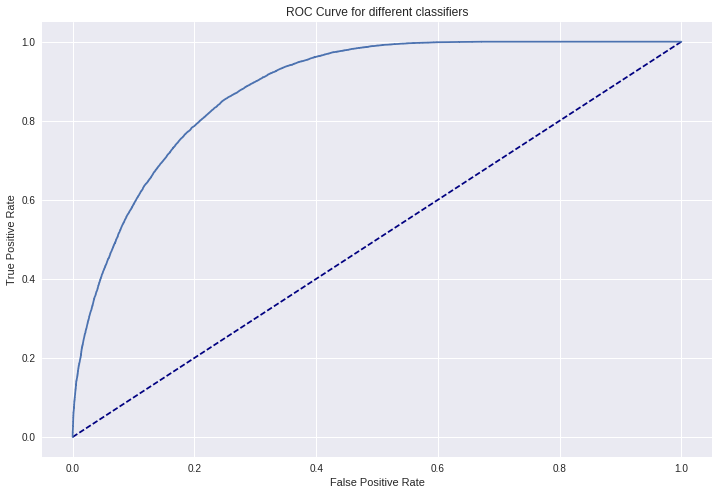

In [46]:
plt.figure(figsize=(12,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different classifiers')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
fpr, tpr, _ = roc_curve(y_test, linked_proba)
roc_auc = auc(fpr, tpr)
print(roc_auc)
print(log_loss(y_test,linked_proba))
plt.plot(fpr, tpr)